In [67]:
import pandas as pd
import numpy as np 
import os
import plotly.express as px
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import random

# For investigating timeseries data
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

# For modeling
import xgboost
from prophet import Prophet

### Loading Data

In [68]:
# Reading Data
base_path =  os.getcwd()
file_name = 'Traffic_Data.xlsx'
total_path = base_path + '//Data//' 
df = pd.read_excel(total_path + file_name, sheet_name='Sheet1')

# Filtering for just one state
df = df[df['State'] == 'Oregon']
df = df.sort_values(by = ['Date'])
df.head(10)


,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
3056,Oregon,West,153,2823,2769,January,1,2019,2019-01-01
3005,Oregon,West,143,2393,2566,February,2,2019,2019-02-01
2954,Oregon,West,153,3088,3104,March,3,2019,2019-03-01
2903,Oregon,West,152,3034,2990,April,4,2019,2019-04-01
2852,Oregon,West,147,3303,3295,May,5,2019,2019-05-01
2801,Oregon,West,154,3334,3318,June,6,2019,2019-06-01
2750,Oregon,West,153,3547,3527,July,7,2019,2019-07-01
2699,Oregon,West,152,3587,3541,August,8,2019,2019-08-01
2648,Oregon,West,155,3246,3216,September,9,2019,2019-09-01
2597,Oregon,West,157,3241,3185,October,10,2019,2019-10-01


### Plotting Data

In [69]:
fig = px.scatter(df, x="Date", y="CMILES", title = 'Miles Driven by Time')
fig.show()

In [70]:
# Replacing outlier January 2023 value
mean_val = df[(df['Month'] == 'January') &
              (df['Year'] != 2023)]['CMILES'].mean()
df['CMILES'] = np.where(df['CMILES'] <1000, mean_val, df['CMILES'])

fig = px.scatter(df, x="Date", y="CMILES", title = 'Miles Driven by Time - Outlier adjusted')
fig.show()

### Seasonal Decomposition

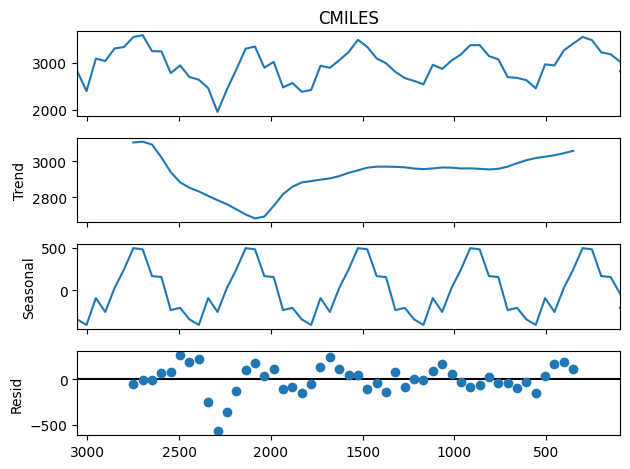

In [71]:
result = seasonal_decompose(df['CMILES'], model='additive', period=12)
result.plot()
pyplot.show()

### Creating Model

In [72]:
model = xgboost.XGBRegressor()

### Transforming Data
For our regressor to work we need to turn the problem from a timeseries problem to a regression one. We can do this by offsetting our dataset by x steps so that we can prediction time T based on teh value at T-x

In [73]:
# Defining function to convert time series problem into supervised learning problem
def convert_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 
 df = pd.DataFrame(data)
 cols = list()
 # Training sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    print(i)
    cols.append(df.shift(i))
    
 # Forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    print(i)
    cols.append(df.shift(-i))

 # Concatenating columns together
 agg = pd.concat(cols, axis=1)
 
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values


# Function to split into test/train set based on time
def train_test_split(data, n_test):
   return data[:-n_test, :], data[-n_test:, :]

# Fit xgboost model based on histroric data and making prediction for next timestamp
def forecast(train, testX):
 
 train = np.asarray(train)
 # splitting into input/output
 x_train, y_train = train[:, :-1], train[:, -1]
 # fitting model
 model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(x_train, y_train)

 # making a prediction
 y_predicted = model.predict(np.asarray([testX]))
 return y_predicted[0]


def stepwise_prediction(data, n_test):
 
 '''Iterates through timeseries data, fitting a new model for data up to
 time t and making prediction for time t+1'''
 
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 print(len(train))
 # seed history with training dataset
 history = [x for x in train] 

 # Iterating through dataset one timestep at a time
 for i in range(len(test)):
   # Creating new test and train dataset for each timestep
   testX, testy = test[i, :-1], test[i, -1]
   # Fitting model and making prediction for next step
   y_pred = forecast(history, testX)
   # store forecast in list of predictions
   predictions.append(y_pred)

 return  predictions

### Fitting Model

In [74]:
values = df['CMILES'].values
print(values)
# Transforming to time series                                                                                                                                                       
data = convert_to_supervised(values, n_in=24)
print(data.shape)
print(data)

[2823. 2393. 3088. 3034. 3303. 3334. 3547. 3587. 3246. 3241. 2778. 2942.
 2694. 2637. 2457. 1949. 2429. 2850. 3299. 3345. 2894. 3017. 2472. 2567.
 2379. 2418. 2935. 2890. 3052. 3226. 3488. 3336. 3092. 2988. 2805. 2671.
 2612. 2537. 2956. 2869. 3044. 3176. 3372. 3376. 3141. 3072. 2692. 2676.
 2627. 2452. 2964. 2942. 3263. 3407. 3549. 3481. 3222. 3180. 2864. 2817.]
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
(36, 25)
[[2823. 2393. 3088. 3034. 3303. 3334. 3547. 3587. 3246. 3241. 2778. 2942.
  2694. 2637. 2457. 1949. 2429. 2850. 3299. 3345. 2894. 3017. 2472. 2567.
  2379.]
 [2393. 3088. 3034. 3303. 3334. 3547. 3587. 3246. 3241. 2778. 2942. 2694.
  2637. 2457. 1949. 2429. 2850. 3299. 3345. 2894. 3017. 2472. 2567. 2379.
  2418.]
 [3088. 3034. 3303. 3334. 3547. 3587. 3246. 3241. 2778. 2942. 2694. 2637.
  2457. 1949. 2429. 2850. 3299. 3345. 2894. 3017. 2472. 2567. 2379. 2418.
  2935.]
 [3034. 3303. 3334. 3547. 3587. 3246. 3241. 2778. 2942. 2694. 2637. 2457.
  1949. 2429. 2

In [75]:
# Setting test dataset size
prediction_count = 12
prediction_dates = df['Date'].sort_values()[-prediction_count:]
print(prediction_dates)
# Making prediction with Xgboost
y_pred = stepwise_prediction(data, prediction_count)
print(y_pred)

608   2023-01-01
557   2023-02-01
506   2023-03-01
455   2023-04-01
404   2023-05-01
353   2023-06-01
302   2023-07-01
251   2023-08-01
200   2023-09-01
149   2023-10-01
47    2023-11-01
98    2023-12-01
Name: Date, dtype: datetime64[ns]
24
[2578.508, 2670.153, 2889.0073, 2890.4727, 3050.5063, 3165.5154, 3369.0864, 3350.576, 3141.0435, 3071.176, 2729.1372, 2674.221]


### Analyzing Results

In [76]:
# Creating dataframe for comparing predicted/actual values
df_comparison = df[['CMILES', 'Date']]
df_comparison['Method'] = 'Actual'

# Converting xgboost predictions to dataframe
xgboost_dict = {'CMILES': y_pred,
                'Date': prediction_dates,
                'Method': 'xgboost'}
xgboost_df = pd.DataFrame.from_dict(xgboost_dict)

# Appending predictions to comparison dataframe   
df_comparison = pd.concat([df_comparison, xgboost_df], ignore_index=True)

C:\Users\seelc\AppData\Local\Temp\ipykernel_28604\1622743148.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Graphing Actual vs Predicted Values

In [77]:
# Calculating MAPE for xgboost
xgboost_mape = round(mean_absolute_percentage_error(xgboost_df['CMILES'], 
                                              df.sort_values(by = ['Date'])[-prediction_count:]['CMILES']),3)

compare_fig = px.line(df_comparison, x = 'Date', y = 'CMILES', color='Method',
                      title = 'Predicted vs Actual Traffic, MAPE: {mape}'.format(mape = xgboost_mape))
compare_fig.show()

### Comparing XGboost with Prophet

In [78]:
prophet_df = df[['CMILES', 'Date']].copy()
prophet_df = prophet_df.rename(columns= {'CMILES':'y',
                                       'Date':'ds'}).reset_index().drop(columns=['index'])
prophet_df.head(10)

,y,ds
0,2823.0,2019-01-01
1,2393.0,2019-02-01
2,3088.0,2019-03-01
3,3034.0,2019-04-01
4,3303.0,2019-05-01
5,3334.0,2019-06-01
6,3547.0,2019-07-01
7,3587.0,2019-08-01
8,3246.0,2019-09-01
9,3241.0,2019-10-01


In [79]:
train, test = prophet_df[:len(prophet_df['y'])-prediction_count], prophet_df[-prediction_count:]
prophet_model = Prophet()
prophet_model.fit(train)
print(test)

20:21:57 - cmdstanpy - INFO - Chain [1] start processing
20:21:57 - cmdstanpy - INFO - Chain [1] done processing


         y         ds
48  2627.0 2023-01-01
49  2452.0 2023-02-01
50  2964.0 2023-03-01
51  2942.0 2023-04-01
52  3263.0 2023-05-01
53  3407.0 2023-06-01
54  3549.0 2023-07-01
55  3481.0 2023-08-01
56  3222.0 2023-09-01
57  3180.0 2023-10-01
58  2864.0 2023-11-01
59  2817.0 2023-12-01


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



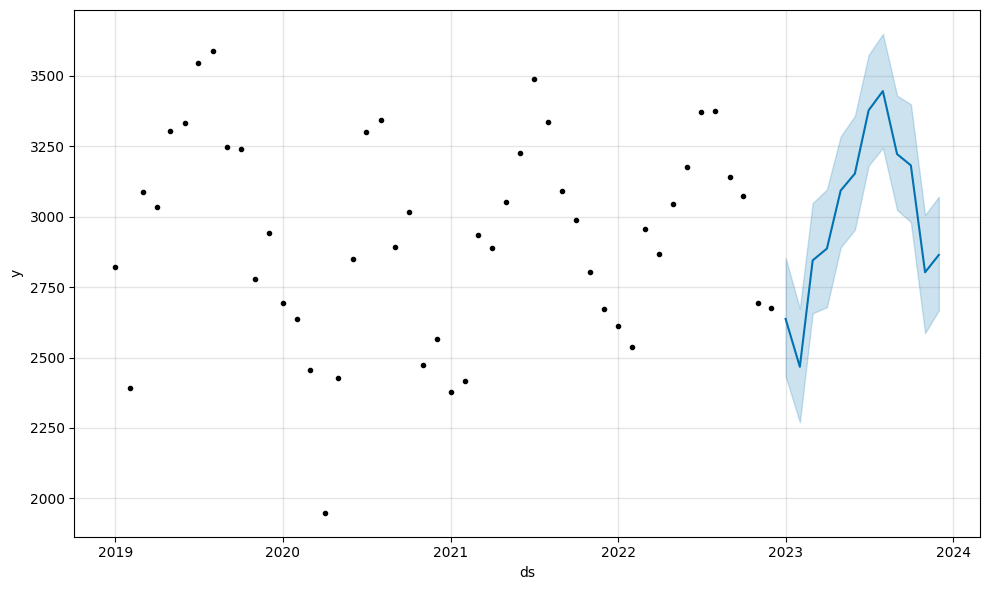

In [80]:
forecast = prophet_model.predict(test)
fig1 = prophet_model.plot(forecast)

### Comparing XGboost and Prophet

In [81]:
y_pred_prophet = forecast['yhat'].values

# Converting prophet predictions to dataframe
prophet_dict = {'CMILES': y_pred_prophet,
                'Date': prediction_dates,
                'Method': 'Prophet'}
prophet_df = pd.DataFrame.from_dict(prophet_dict)

# Appending predictions to comparison dataframe   
df_comparison = pd.concat([df_comparison, prophet_df], ignore_index=True)

In [82]:
# Calculating MAPE for xprophet
prophet_mape = round(mean_absolute_percentage_error(y_pred_prophet, 
                                              df.sort_values(by = ['Date'])[-prediction_count:]['CMILES']),3)

compare_fig = px.line(df_comparison, x = 'Date', y = 'CMILES', color='Method',
                      title = 'Predicted vs Actual Traffic, XGboost MAPE: {mape_g} , Prophet MAPE: {mape_p} '.format(mape_g = xgboost_mape, mape_p = prophet_mape))
compare_fig.show()